<a href="https://colab.research.google.com/github/serenabooth/Scaffolding_RL/blob/master/Scaffolding_RL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit: https://cgnicholls.github.io/reinforcement-learning/2017/03/27/a3c.html

In [1]:
!apt-get update
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym
!pip install "gym[atari]"
!pip install tqdm
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 3s (100 kB/s)
Reading package lists... Done
Reading package lists... Done
Building 

In [0]:
from pyvirtualdisplay import Display
from IPython.core import display
from scipy.misc import imresize
import gym
from gym.core import Wrapper
from gym.spaces.box import Box
import tensorflow as tf
import os
import sys, getopt
import threading
import numpy as np
from time import time, sleep
import queue
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
# Train for this many steps
T_MAX = 100000000
# Use this many threads
NUM_THREADS = 8
# Initial learning rate for Adam
INITIAL_LEARNING_RATE = 1e-4
# The discount factor
DISCOUNT_FACTOR = 0.99
# Evaluate the agent and print out average reward every this many steps
VERBOSE_EVERY = 40000
# Update the parameters in each thread after this many steps in that thread
I_ASYNC_UPDATE = 5
TESTING = False


FLAGS = {"T_MAX": T_MAX, "NUM_THREADS": NUM_THREADS, "INITIAL_LEARNING_RATE":
INITIAL_LEARNING_RATE, "DISCOUNT_FACTOR": DISCOUNT_FACTOR, "VERBOSE_EVERY":
VERBOSE_EVERY, "TESTING": TESTING, "I_ASYNC_UPDATE": I_ASYNC_UPDATE}

# Use this global variable to exit the training loop in each thread once we've finished.
training_finished = False

In [0]:
env = gym.make('SpaceInvaders-v0')

In [0]:
# A wrapper class for Open AI Gym.
class CustomGym(Wrapper):
    def __init__(self, env, game_name, skip_actions=4, num_frames=4, w=84, h=84, dim_order='theano', color=False, crop=lambda img: img):
      # game_name: the name of the Open AI Gym environment
      # skip_actions: the number of frames to repeat an action for
      # num_frames: the number of frames to stack in one state
      # w: width of the state input
      # h: height of the state input.
      super(CustomGym, self).__init__(env)

      #self.env = gym.make(game_name)
      self.crop = crop
      self.num_frames = num_frames
      self.skip_actions = skip_actions
      self.w = w
      self.h = h
      self.dim_order = dim_order
      self.color = color
      
      n_channels = (3 * num_frames) if color else num_frames
      obs_shape = [n_channels,h,w] if dim_order == 'theano' else [h,w,n_channels]
      self.observation_space = Box(0.0, 1.0, obs_shape)
      self.framebuffer = np.zeros(obs_shape, 'float32')

#       # For some of the ATARI games the action spaces are much larger than we want
#       # and contain repeated actions, so I worked out simplified actions for these
#       # games.
#       if game_name == 'SpaceInvaders-v0':
#         self.action_space = [1,2,3]
#       elif game_name == 'Pong-v0':
#         self.action_space = [1,2,3]
#       elif game_name == 'Breakout-v0':
#         self.action_space = [1,4,5]
#       else:
#         # Otherwise, use the actions specified by Open AI.
#         self.action_space = env.action_space

      # Store the rest.
      self.action_size = self.action_space.n
      self.game_name = game_name
    
    def update_buffer(self,img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        #img = imresize(img, self.img_size)
        img = np.array(Image.fromarray(img).resize((self.w, self.h)))
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2,0,1]) # [h, w, c] to [c, h, w]
        img = img.astype('float32') / 255.
        return img

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    # Step the environment with the given action.
    def step(self, action):
      #action = self.action_space[action_idx]
      accum_reward = 0
      prev_s = None
      for _ in range(self.skip_actions):
        s, r, term, info = self.env.step(action)
        accum_reward += r
        if term:
          break
        prev_s = s
      self.update_buffer(s)

      # Takes maximum value for each pixel value over the current and previous
      # frame. Used to get round Atari sprites flickering (Mnih et al. (2015))
      if self.game_name == 'SpaceInvaders-v0' and prev_s is not None:
        s = np.maximum.reduce([s, prev_s])
      return self.framebuffer, accum_reward, term, info

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Observation shape: (42, 42, 4)
Num actions: 6
Action names: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


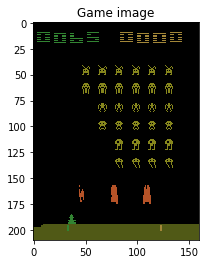

(42, 42, 4)


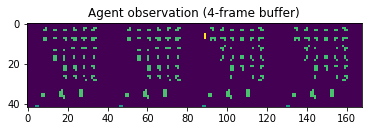

In [9]:
def make_env(game_name):
    env = gym.make(game_name)
    env = CustomGym(env, game_name=game_name, h=42, w=42,
                          crop = lambda img: img[35:-20, 20:],
                          dim_order = 'tensorflow',
                          color=False, num_frames=4)
    return env

env = make_env("SpaceInvaders-v0")

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
print (env.observation_space.shape)
plt.imshow(s.transpose([0,2,1]).reshape([42,-1]))
plt.show()

In [0]:
class Agent():
    def __init__(self, session, action_size, model='mnih',
        optimizer=tf.train.AdamOptimizer(1e-4)):

        self.action_size = action_size
        self.optimizer = optimizer
        self.sess = session

        with tf.variable_scope('network'):
            self.action = tf.placeholder('int32', [None], name='action')
            self.target_value = tf.placeholder('float32', [None], name='target_value')
            if model == 'mnih':
                self.state, self.policy, self.value = self.build_model(42, 42, 4)
            else:
                # Assume we wanted a feedforward neural network
                self.state, self.policy, self.value = self.build_model_feedforward(3)
            self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
            scope='network')
            self.advantages = tf.placeholder('float32', [None], name='advantages')

        with tf.variable_scope('optimizer'):
            # Compute the one hot vectors for each action given.
            action_one_hot = tf.one_hot(self.action, self.action_size, 1.0, 0.0)

            min_policy = 1e-8
            max_policy = 1.0 - 1e-8
            self.log_policy = tf.log(tf.clip_by_value(self.policy, 0.000001, 0.999999))

            # For a given state and action, compute the log of the policy at
            # that action for that state. This also works on batches.
            self.log_pi_for_action = tf.reduce_sum(tf.multiply(self.log_policy, action_one_hot), reduction_indices=1)

            # Takes in R_t - V(s_t) as in the async paper. Note that we feed in
            # the advantages so that V(s_t) is treated as a constant for the
            # gradient. This is because V(s_t) is the baseline (called 'b' in
            # the REINFORCE algorithm). As long as the baseline is constant wrt
            # the parameters we are optimising (in this case those for the
            # policy), then the expected value of grad_theta log pi * b is zero,
            # so the choice of b doesn't affect the expectation. It reduces the
            # variance though.
            # We want to do gradient ascent on the expected discounted reward.
            # The gradient of the expected discounted reward is the gradient of
            # log pi * (R - estimated V), where R is the sampled reward from the
            # given state following the policy pi. Since we want to maximise
            # this, we define the policy loss as the negative and get tensorflow
            # to do the automatic differentiation for us.
            self.policy_loss = -tf.reduce_mean(self.log_pi_for_action * self.advantages)

            # The value loss is much easier to understand: we want our value
            # function to accurately estimated the sampled discounted rewards,
            # so we just impose a square error loss.
            # Note that the target value should be the discounted reward for the
            # state as just sampled.
            self.value_loss = tf.reduce_mean(tf.square(self.target_value - self.value))

            # We follow Mnih's paper and introduce the entropy as another loss
            # to the policy. The entropy of a probability distribution is just
            # the expected value of - log P(X), denoted E(-log P(X)), which we
            # can compute for our policy at any given state with
            # sum(policy * -log(policy)), as below. This will be a positive
            # number, since self.policy contains numbers between 0 and 1, so the
            # log is negative. Note that entropy is smaller when the probability
            # distribution is more concentrated on one action, so a larger
            # entropy implies more exploration. Thus we penalise small entropy,
            # or equivalently, add -entropy to our loss.
            self.entropy = tf.reduce_sum(tf.multiply(self.policy, -self.log_policy))

            # Try to minimise the loss. There is some rationale for choosing the
            # weighted linear combination here that I found somewhere else that
            # I can't remember, but I haven't tried to optimise it.
            # Note the negative entropy term, which encourages exploration:
            # higher entropy corresponds to less certainty.
            self.loss = 0.5 * self.value_loss + self.policy_loss - self.entropy\
            * 0.01

            # Compute the gradient of the loss with respect to all the weights,
            # and create a list of tuples consisting of the gradient to apply to
            # the weight.
            grads = tf.gradients(self.loss, self.weights)
            grads, _ = tf.clip_by_global_norm(grads, 40.0)
            grads_vars = list(zip(grads, self.weights))

            # Create an operator to apply the gradients using the optimizer.
            # Note that apply_gradients is the second part of minimize() for the
            # optimizer, so will minimize the loss.
            self.train_op = optimizer.apply_gradients(grads_vars)

    def get_policy(self, state):
        return self.sess.run(self.policy, {self.state: state}).flatten()

    def get_value(self, state):
        return self.sess.run(self.value, {self.state: state}).flatten()

    def get_policy_and_value(self, state):
        policy, value = self.sess.run([self.policy, self.value], {self.state:
        state})
        return policy.flatten(), value.flatten()

    # Train the network on the given states and rewards
    def train(self, states, actions, target_values, advantages):
        # Training
        self.sess.run(self.train_op, feed_dict={
            self.state: states,
            self.action: actions,
            self.target_value: target_values,
            self.advantages: advantages
        })

    # Builds the DQN model as in Mnih, but we get a softmax output for the
    # policy from fc1 and a linear output for the value from fc1.
    def build_model(self, h, w, channels):
        self.layers = {}
        state = tf.placeholder('float32', shape=(h, w, channels), name='state')
        self.layers['state'] = state
        # First convolutional layer
        with tf.variable_scope('conv1'):
            conv1 = tf.contrib.layers.convolution2d(inputs=state,
            num_outputs=16, kernel_size=[8,8], stride=[4,4], padding="VALID",
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
            biases_initializer=tf.zeros_initializer())
            self.layers['conv1'] = conv1

        # Second convolutional layer
        with tf.variable_scope('conv2'):
            conv2 = tf.contrib.layers.convolution2d(inputs=conv1, num_outputs=32,
            kernel_size=[4,4], stride=[2,2], padding="VALID",
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
            biases_initializer=tf.zeros_initializer())
            self.layers['conv2'] = conv2

        # Flatten the network
        with tf.variable_scope('flatten'):
            flatten = tf.contrib.layers.flatten(inputs=conv2)
            self.layers['flatten'] = flatten

        # Fully connected layer with 256 hidden units
        with tf.variable_scope('fc1'):
            fc1 = tf.contrib.layers.fully_connected(inputs=flatten, num_outputs=256,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=tf.zeros_initializer())
            self.layers['fc1'] = fc1

        # The policy output
        with tf.variable_scope('policy'):
            policy = tf.contrib.layers.fully_connected(inputs=fc1,
            num_outputs=self.action_size, activation_fn=tf.nn.softmax,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=None)
            self.layers['policy'] = policy

        # The value output
        with tf.variable_scope('value'):
            value = tf.contrib.layers.fully_connected(inputs=fc1, num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=None)
            self.layers['value'] = value

        return state, policy, value

    # Builds a simple feedforward model to learn the cart and pole environment.
    def build_model_feedforward(self, input_dim, num_hidden=30):
        self.layers = {}
        state = tf.placeholder('float32', shape=(None, input_dim), name='state')

        self.layers['state'] = state
        # Fully connected layer with num_hidden hidden units
        with tf.variable_scope('fc1'):
            fc1 = tf.contrib.layers.fully_connected(inputs=state,
            num_outputs=num_hidden,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=tf.zeros_initializer())
            self.layers['fc1'] = fc1

        # Fully connected layer with num_hidden hidden units
        with tf.variable_scope('fc2'):
            fc2 = tf.contrib.layers.fully_connected(inputs=fc1,
            num_outputs=num_hidden,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=tf.zeros_initializer())
            self.layers['fc2'] = fc2

        # The policy output to the two possible actions
        with tf.variable_scope('policy'):
            policy = tf.contrib.layers.fully_connected(inputs=fc2,
            num_outputs=self.action_size, activation_fn=tf.nn.softmax,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=tf.zeros_initializer())
            self.layers['policy'] = policy

        # The value output
        with tf.variable_scope('value'):
            value = tf.contrib.layers.fully_connected(inputs=fc2, num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=tf.zeros_initializer())
            self.layers['value'] = value

        return state, policy, value

In [0]:
class Summary:
    def __init__(self, logdir, agent):
        with tf.variable_scope('summary'):
            summarising = ['episode_avg_reward', 'avg_value']
            self.agent = agent
            self.writer = tf.summary.FileWriter(logdir, self.agent.sess.graph)
            self.summary_ops = {}
            self.summary_vars = {}
            self.summary_ph = {}
            for s in summarising:
                self.summary_vars[s] = tf.Variable(0.0)
                self.summary_ph[s] = tf.placeholder('float32', name=s)
                self.summary_ops[s] = tf.summary.scalar(s, self.summary_vars[s])
            self.update_ops = []
            for k in self.summary_vars:
                self.update_ops.append(self.summary_vars[k].assign(self.summary_ph[k]))
            self.summary_op = tf.summary.merge(list(self.summary_ops.values()))

    def write_summary(self, summary, t):
        self.agent.sess.run(self.update_ops, {self.summary_ph[k]: v for k, v in summary.items()})
        summary_to_add = self.agent.sess.run(self.summary_op, {self.summary_vars[k]: v for k, v in summary.items()})
        self.writer.add_summary(summary_to_add, global_step=t)

def async_trainer(agent, env, sess, thread_idx, T_queue, summary, saver,
    save_path):
    print ("Training thread", thread_idx)
    T = T_queue.get()
    T_queue.put(T+1)
    t = 0

    last_verbose = T
    last_time = time()
    last_target_update = T

    terminal = True
    while T < T_MAX:
        t_start = t
        batch_states = []
        batch_rewards = []
        batch_actions = []
        baseline_values = []

        if terminal:
            terminal = False
            state = env.reset()

        while not terminal and len(batch_states) < I_ASYNC_UPDATE:
            # Save the current state
            batch_states.append(state)

            # Choose an action randomly according to the policy
            # probabilities. We do this anyway to prevent us having to compute
            # the baseline value separately.
            policy, value = agent.get_policy_and_value(state)
            action_idx = np.random.choice(agent.action_size, p=policy)

            # Take the action and get the next state, reward and terminal.
            state, reward, terminal, _ = env.step(action_idx)

            # Update counters
            t += 1
            T = T_queue.get()
            T_queue.put(T+1)

            # Clip the reward to be between -1 and 1
            reward = np.clip(reward, -1, 1)

            # Save the rewards and actions
            batch_rewards.append(reward)
            batch_actions.append(action_idx)
            baseline_values.append(value[0])

        target_value = 0
        # If the last state was terminal, just put R = 0. Else we want the
        # estimated value of the last state.
        if not terminal:
            target_value = agent.get_value(state)[0]
        last_R = target_value

        # Compute the sampled n-step discounted reward
        batch_target_values = []
        for reward in reversed(batch_rewards):
            target_value = reward + DISCOUNT_FACTOR * target_value
            batch_target_values.append(target_value)
        # Reverse the batch target values, so they are in the correct order
        # again.
        batch_target_values.reverse()

        # Test batch targets
        if TESTING:
            temp_rewards = batch_rewards + [last_R]
            test_batch_target_values = []
            for j in range(len(batch_rewards)):
                test_batch_target_values.append(discount(temp_rewards[j:], DISCOUNT_FACTOR))
            if not test_equals(batch_target_values, test_batch_target_values,
                1e-5):
                print ("Assertion failed")
                print (last_R)
                print (batch_rewards)
                print (batch_target_values)
                print (test_batch_target_values)

        # Compute the estimated value of each state
        batch_advantages = np.array(batch_target_values) - np.array(baseline_values)

        # Apply asynchronous gradient update
        agent.train(np.vstack(batch_states), batch_actions, batch_target_values,
        batch_advantages)

    global training_finished
    training_finished = True

def estimate_reward(agent, env, episodes=10, max_steps=10000):
    episode_rewards = []
    episode_vals = []
    t = 0
    for i in range(episodes):
        episode_reward = 0
        state = env.reset()
        terminal = False
        while not terminal:
            policy, value = agent.get_policy_and_value(state)
            action_idx = np.random.choice(agent.action_size, p=policy)
            state, reward, terminal, _ = env.step(action_idx)
            t += 1
            episode_vals.append(value)
            episode_reward += reward
            if t > max_steps:
                episode_rewards.append(episode_reward)
                return episode_rewards, episode_vals
        episode_rewards.append(episode_reward)
    return episode_rewards, episode_vals

def evaluator(agent, env, sess, T_queue, summary, saver, save_path):
    # Read T and put the same T back on.
    T = T_queue.get()
    T_queue.put(T)
    last_time = time()
    last_verbose = T
    while T < T_MAX:
        T = T_queue.get()
        T_queue.put(T)
        if T - last_verbose >= VERBOSE_EVERY:
            print ("T", T)
            current_time = time()
            print ("Train steps per second", float(T - last_verbose) / (current_time - last_time))
            last_time = current_time
            last_verbose = T

            print ("Evaluating agent")
            episode_rewards, episode_vals = estimate_reward(agent, env, episodes=5)
            avg_ep_r = np.mean(episode_rewards)
            avg_val = np.mean(episode_vals)
            print ("Avg ep reward", avg_ep_r, "Average value", avg_val)

            summary.write_summary({'episode_avg_reward': avg_ep_r, 'avg_value': avg_val}, T)
            checkpoint_file = saver.save(sess, save_path, global_step=T)
            print ("Saved in", checkpoint_file)
        sleep(1.0)

# If restore is True, then start the model from the most recent checkpoint.
# Else initialise as usual.
def a3c(game_name, num_threads=8, restore=None, save_path='model'):
    processes = []
    envs = []
    for _ in range(num_threads+1):
        gym_env = gym.make(game_name)
        # if game_name == 'CartPole-v0':
        #     env = CustomGymClassicControl(game_name)
        # else:
        print ("Assuming ATARI game and playing with pixels")
        env = make_env(game_name)
        envs.append(env)

    # Separate out the evaluation environment
    evaluation_env = envs[0]
    envs = envs[1:]

    with tf.Session() as sess:
        agent = Agent(session=sess,
        action_size=envs[0].action_size, model='mnih',
        optimizer=tf.train.AdamOptimizer(INITIAL_LEARNING_RATE))

        # Create a saver, and only keep 2 checkpoints.
        saver = tf.train.Saver(max_to_keep=2)

        T_queue = queue.Queue()

        # Either restore the parameters or don't.
        if restore is not None:
            saver.restore(sess, save_path + '-' + str(restore))
            last_T = restore
            print ("T was:", last_T)
            T_queue.put(last_T)
        else:
            sess.run(tf.global_variables_initializer())
            T_queue.put(0)

        summary = Summary(save_path, agent)

        # Create a process for each worker
        for i in range(num_threads):
            processes.append(threading.Thread(target=async_trainer, args=(agent,
            envs[i], sess, i, T_queue, summary, saver, save_path,)))

        # Create a process to evaluate the agent
        processes.append(threading.Thread(target=evaluator, args=(agent,
        evaluation_env, sess, T_queue, summary, saver, save_path,)))

        # Start all the processes
        for p in processes:
            p.daemon = True
            p.start()

        # Until training is finished
        while not training_finished:
            sleep(0.01)

        # Join the processes, so we get this thread back.
        for p in processes:
            p.join()

# Returns sum(rewards[i] * gamma**i)
def discount(rewards, gamma):
    return np.sum([rewards[i] * gamma**i for i in range(len(rewards))])

def test_equals(arr1, arr2, eps):
    return np.sum(np.abs(np.array(arr1)-np.array(arr2))) < eps


In [12]:
a3c(game_name='SpaceInvaders-v0')

Assuming ATARI game and playing with pixels


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



ValueError: ignored